# EDA and Word Feature Importance

In [1]:
#!pip install wordcloud

In [2]:
import pandas as pd
import numpy as np
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from wordcloud import WordCloud
import matplotlib.pyplot as plt

## Read the dataset and handling null values

In [3]:
df = pd.read_csv("sentiment_analysis_results.csv", low_memory=False)
df.dropna(subset=["content"], inplace=True)
df['followersCount'] = pd.to_numeric(df['followersCount'], errors='coerce')
df = df.dropna(subset=['followersCount'])
df['friendsCount'] = pd.to_numeric(df['friendsCount'], errors='coerce')
df = df.dropna(subset=['friendsCount'])
df['mediaCount'] = pd.to_numeric(df['mediaCount'], errors='coerce')
df = df.dropna(subset=['mediaCount'])
df

,url,date,content,likeCount,replyCount,retweetCount,viewCount,quoteCount,sourceLabel,links,...,username,UserDescription,UserFavouritesCount,followersCount,friendsCount,location,verified,protected,mediaCount,predicted_sentiment
0,https://twitter.com/LaTera__/status/1477429429...,2022-01-01 23:59:59+00:00,I’m getting a sugar daddy this year!,0.0,10.0,0,210.006559,0,Twitter for iPhone,NaN,...,LaTera__,NCAT Alumna |🪬 | | For giggles,54402,1955.0,740,Michigan,False,False,2636.0,Neutral
1,https://twitter.com/allirica_rose/status/14774...,2022-01-01 23:59:59+00:00,might make em french toast after and spoon a l...,1.0,0.0,0,191.910011,0,Twitter for iPhone,NaN,...,allirica_rose,"writer, reader, horror lover, general disaster...",12135,65.0,98,NaN,False,False,375.0,Negative
2,https://twitter.com/matrixlms/status/147742942...,2022-01-01 23:59:59+00:00,Our platform can be matched to your company’s ...,0.0,0.0,0,210.006559,0,HubSpot,"[TextLink(text='hubs.ly/Q011g-C00', url='https...",...,matrixlms,An innovative way to train and learn. \nSign u...,2145,10074.0,10523,"Plano, TX 75024",False,False,8275.0,Positive
3,https://twitter.com/AnarkyIsMe/status/14774294...,2022-01-01 23:59:59+00:00,Oh my God this first song. I can't with how am...,5.0,2.0,0,542.144594,0,Twitter for Android,"[TextLink(text='youtu.be/tA0-WXsm-T0', url='ht...",...,AnarkyIsMe,Vegan activist trying to make a change in the ...,8130,1507.0,1092,Earth 🌍,False,False,1760.0,Positive
4,https://twitter.com/__amyya/status/14774294292...,2022-01-01 23:59:59+00:00,Happy new year ! 😚🎉,1.0,0.0,0,191.910011,0,Twitter for iPhone,NaN,...,__amyya,5♥5♥5,39943,590.0,179,Lost in thought,False,False,625.0,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547479,https://twitter.com/DBKyei/status/157599882727...,2022-09-30 23:59:35+00:00,ECG be the source 😂✌🏽,1.0,0.0,0,191.910011,0,Twitter for Android,NaN,...,DBKyei,Jesus 💜 | ART PR @artblockgh1 ||\n🎪 @DBkyeiEve...,40961,1106.0,2107,worldwide,False,False,532.0,Neutral
547480,https://twitter.com/monseuljoy/status/15759988...,2022-09-30 23:59:35+00:00,i’m hungry,1.0,1.0,0,191.910011,0,Twitter for iPhone,NaN,...,monseuljoy,element 85 astatine,31144,2.0,2,,False,False,570.0,Neutral
547481,https://twitter.com/bxnicholee/status/15759988...,2022-09-30 23:59:35+00:00,Playing bad bunny all shift bc customers are b...,1.0,0.0,0,191.910011,0,Twitter for iPhone,NaN,...,bxnicholee,bcn | 20,10882,1002.0,361,NaN,False,False,104.0,Negative
547482,https://twitter.com/craigularguy_/status/15759...,2022-09-30 23:59:35+00:00,this is me btw. when you're mean to me this is...,12.0,2.0,0,1266.260482,0,Twitter for iPhone,NaN,...,craigularguy_,"aspiring dude, accomplished guy, and occasiona...",14757,101.0,498,"Cow Roast, England",False,False,361.0,Negative


## Applying Data transformations

Transorming the links, media, quotedTweet, mentionedUsers into categorical variables for the analysis.

Imputing verified and protected with FALSE

In [4]:
df['links'] = df['links'].apply(lambda x: 0 if pd.isna(x) or x == '' else 1)
df['media'] = df['media'].apply(lambda x: 0 if pd.isna(x) or x == '' else 1)
df['quotedTweet'] = df['quotedTweet'].apply(lambda x: 0 if pd.isna(x) or x == '' else 1)
df['mentionedUsers'] = df['mentionedUsers'].apply(lambda x: 0 if pd.isna(x) or x == '' else 1)
df['verified'] = df['verified'].fillna(False).astype(int)
df['protected'] = df['protected'].fillna(False).astype(int)

C:\Users\varsh\AppData\Local\Temp\ipykernel_21952\1344441066.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['verified'] = df['verified'].fillna(False).astype(int)
C:\Users\varsh\AppData\Local\Temp\ipykernel_21952\1344441066.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['protected'] = df['protected'].fillna(False).astype(int)


## Preprocessing the text

In [5]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove other non-word characters, numbers, etc., if you wish
    text = re.sub(r'\W+|\d+', ' ', text)
    return text

In [6]:
df['clean_content'] = df['content'].apply(clean_text)

In [7]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['tokenized'] = df['clean_content'].apply(lambda x: [word for word in x.split() if word not in (stop)])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\varsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
df['cleaned_text'] = df['tokenized'].apply(lambda x: ' '.join(x))

In [9]:
df['cleaned_text']

0                                I getting sugar daddy year
1                   might make em french toast spoon little
2         Our platform matched company brand adding pers...
3         Oh God first song I amazing chick All live hit...
4                                            Happy new year
                                ...                        
547479                                           ECG source
547480                                               hungry
547481            Playing bad bunny shift bc customers rude
547482                                        btw mean mean
547483    President Zelensky said submitting fast tracke...
Name: cleaned_text, Length: 547476, dtype: object

## Scaling

In [10]:
df['likeCount_log'] = np.log1p(df['likeCount'])
df['replyCount_log'] = np.log1p(df['replyCount'])
df['viewCount_log'] = np.log1p(df['viewCount'])

In [11]:
df.loc[:, 'followersCount'] = pd.to_numeric(df['followersCount'], errors='coerce')
df = df.dropna(subset=['followersCount'])

In [12]:
print(df.dtypes)

url                     object
date                    object
content                 object
likeCount              float64
replyCount             float64
retweetCount            object
viewCount              float64
quoteCount              object
sourceLabel             object
links                    int64
media                    int64
quotedTweet              int64
mentionedUsers           int64
coordinates             object
place                   object
hashtags                object
cashtags                object
card                    object
vibe                    object
username                object
UserDescription         object
UserFavouritesCount     object
followersCount         float64
friendsCount             int64
location                object
verified                 int32
protected                int32
mediaCount             float64
predicted_sentiment     object
clean_content           object
tokenized               object
cleaned_text            object
likeCoun

## Splitting user groups

Calculating the user popularity using followersCount and friendsCount

Scaling them at 0-80 percentile as low and 80-100 percentile as high

In [13]:
popularity_features_log = ['followersCount','friendsCount']

#scaler_pop = MinMaxScaler()
#scaled_data = scaler_pop.fit_transform(df[popularity_features_log])
#for i, col in enumerate(popularity_features_log):
#    df[col + '_scaled'] = scaled_data[:, i]

df.loc[:, 'totalpop'] = df['followersCount'] + df['friendsCount']
q_pop = [0, 0.80, 1]
df.loc[:, 'userpopularity'] = pd.qcut(df['totalpop'], q=q_pop, labels=['Low', 'High'])

In [14]:
df['userpopularity'].value_counts()

userpopularity
Low     437983
High    109493
Name: count, dtype: int64

## Splitting Virality groups

Calculating virality using log values of likeCount, replyCount and viewCount

Scaling accross the respective columns and summed to get the virality score

In [15]:
features_log = ['likeCount_log', 'replyCount_log', 'viewCount_log']
scaler = MinMaxScaler()
df.loc[:, features_log] = scaler.fit_transform(df[features_log])

In [16]:
df['totalScore'] = df['likeCount_log'] + df['replyCount_log'] + df['viewCount_log']

In [17]:
features = ['likeCount','replyCount','viewCount','likeCount_log','replyCount_log','viewCount_log','totalScore']
df[features]

,likeCount,replyCount,viewCount,likeCount_log,replyCount_log,viewCount_log,totalScore
0,0.0,10.0,210.006559,0.000000,0.252670,0.008531,0.261200
1,1.0,0.0,191.910011,0.051995,0.000000,0.000000,0.051995
2,0.0,0.0,210.006559,0.000000,0.000000,0.008531,0.008531
3,5.0,2.0,542.144594,0.134405,0.115762,0.098485,0.348653
4,1.0,0.0,191.910011,0.051995,0.000000,0.000000,0.051995
...,...,...,...,...,...,...,...
547479,1.0,0.0,191.910011,0.051995,0.000000,0.000000,0.051995
547480,1.0,1.0,191.910011,0.051995,0.073038,0.000000,0.125033
547481,1.0,0.0,191.910011,0.051995,0.000000,0.000000,0.051995
547482,12.0,2.0,1266.260482,0.192404,0.115762,0.179092,0.487259


Scaling the virality at 0-90 percentile as low and 90-100 percentile as high

In [18]:
q=[0, 0.90, 1]
labels=['Low', 'High']
df['ViralGroup'] = pd.qcut(df['totalScore'], q=q, labels=labels)

In [19]:
processed = ['content','likeCount','replyCount','viewCount','likeCount_log','replyCount_log','viewCount_log','totalScore','ViralGroup']
df[processed].to_csv('dataset_score.csv', index=False)

In [20]:
df

,url,date,content,likeCount,replyCount,retweetCount,viewCount,quoteCount,sourceLabel,links,...,clean_content,tokenized,cleaned_text,likeCount_log,replyCount_log,viewCount_log,totalpop,userpopularity,totalScore,ViralGroup
0,https://twitter.com/LaTera__/status/1477429429...,2022-01-01 23:59:59+00:00,I’m getting a sugar daddy this year!,0.0,10.0,0,210.006559,0,Twitter for iPhone,0,...,I m getting a sugar daddy this year,"[I, getting, sugar, daddy, year]",I getting sugar daddy year,0.000000,0.252670,0.008531,2695.0,Low,0.261200,Low
1,https://twitter.com/allirica_rose/status/14774...,2022-01-01 23:59:59+00:00,might make em french toast after and spoon a l...,1.0,0.0,0,191.910011,0,Twitter for iPhone,0,...,might make em french toast after and spoon a l...,"[might, make, em, french, toast, spoon, little]",might make em french toast spoon little,0.051995,0.000000,0.000000,163.0,Low,0.051995,Low
2,https://twitter.com/matrixlms/status/147742942...,2022-01-01 23:59:59+00:00,Our platform can be matched to your company’s ...,0.0,0.0,0,210.006559,0,HubSpot,1,...,Our platform can be matched to your company s ...,"[Our, platform, matched, company, brand, addin...",Our platform matched company brand adding pers...,0.000000,0.000000,0.008531,20597.0,High,0.008531,Low
3,https://twitter.com/AnarkyIsMe/status/14774294...,2022-01-01 23:59:59+00:00,Oh my God this first song. I can't with how am...,5.0,2.0,0,542.144594,0,Twitter for Android,1,...,Oh my God this first song I can t with how ama...,"[Oh, God, first, song, I, amazing, chick, All,...",Oh God first song I amazing chick All live hit...,0.134405,0.115762,0.098485,2599.0,Low,0.348653,Low
4,https://twitter.com/__amyya/status/14774294292...,2022-01-01 23:59:59+00:00,Happy new year ! 😚🎉,1.0,0.0,0,191.910011,0,Twitter for iPhone,0,...,Happy new year,"[Happy, new, year]",Happy new year,0.051995,0.000000,0.000000,769.0,Low,0.051995,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547479,https://twitter.com/DBKyei/status/157599882727...,2022-09-30 23:59:35+00:00,ECG be the source 😂✌🏽,1.0,0.0,0,191.910011,0,Twitter for Android,0,...,ECG be the source,"[ECG, source]",ECG source,0.051995,0.000000,0.000000,3213.0,Low,0.051995,Low
547480,https://twitter.com/monseuljoy/status/15759988...,2022-09-30 23:59:35+00:00,i’m hungry,1.0,1.0,0,191.910011,0,Twitter for iPhone,0,...,i m hungry,[hungry],hungry,0.051995,0.073038,0.000000,4.0,Low,0.125033,Low
547481,https://twitter.com/bxnicholee/status/15759988...,2022-09-30 23:59:35+00:00,Playing bad bunny all shift bc customers are b...,1.0,0.0,0,191.910011,0,Twitter for iPhone,0,...,Playing bad bunny all shift bc customers are b...,"[Playing, bad, bunny, shift, bc, customers, rude]",Playing bad bunny shift bc customers rude,0.051995,0.000000,0.000000,1363.0,Low,0.051995,Low
547482,https://twitter.com/craigularguy_/status/15759...,2022-09-30 23:59:35+00:00,this is me btw. when you're mean to me this is...,12.0,2.0,0,1266.260482,0,Twitter for iPhone,0,...,this is me btw when you re mean to me this is ...,"[btw, mean, mean]",btw mean mean,0.192404,0.115762,0.179092,599.0,Low,0.487259,Low


In [21]:
def apply_qcut(group):
    group['ViralGroupAdjusted'] = pd.qcut(group['totalScore'], q=[0, 0.90, 1], labels=['Low','High'])
    return group

In [22]:
df = df.groupby('userpopularity').apply(apply_qcut).reset_index(drop=True)

C:\Users\varsh\AppData\Local\Temp\ipykernel_21952\2446245448.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby('userpopularity').apply(apply_qcut).reset_index(drop=True)
C:\Users\varsh\AppData\Local\Temp\ipykernel_21952\2446245448.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('userpopularity').apply(apply_qcut).reset_index(drop=True)


In [23]:
df.groupby(['userpopularity', 'ViralGroupAdjusted']).size().reset_index(name='count')

C:\Users\varsh\AppData\Local\Temp\ipykernel_21952\1505312030.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['userpopularity', 'ViralGroupAdjusted']).size().reset_index(name='count')


,userpopularity,ViralGroupAdjusted,count
0,Low,Low,394212
1,Low,High,43771
2,High,Low,98545
3,High,High,10948


In [24]:
df.columns

Index(['url', 'date', 'content', 'likeCount', 'replyCount', 'retweetCount',
       'viewCount', 'quoteCount', 'sourceLabel', 'links', 'media',
       'quotedTweet', 'mentionedUsers', 'coordinates', 'place', 'hashtags',
       'cashtags', 'card', 'vibe', 'username', 'UserDescription',
       'UserFavouritesCount', 'followersCount', 'friendsCount', 'location',
       'verified', 'protected', 'mediaCount', 'predicted_sentiment',
       'clean_content', 'tokenized', 'cleaned_text', 'likeCount_log',
       'replyCount_log', 'viewCount_log', 'totalpop', 'userpopularity',
       'totalScore', 'ViralGroup', 'ViralGroupAdjusted'],
      dtype='object')

In [25]:
grouped_df = df.groupby('ViralGroup')['totalScore'].mean()
grouped_df

C:\Users\varsh\AppData\Local\Temp\ipykernel_21952\846364098.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby('ViralGroup')['totalScore'].mean()


ViralGroup
Low     0.207255
High    0.874656
Name: totalScore, dtype: float64

In [26]:
grouped_df = df.groupby('ViralGroup').size()
grouped_df

C:\Users\varsh\AppData\Local\Temp\ipykernel_21952\584163620.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby('ViralGroup').size()


ViralGroup
Low     492736
High     54740
dtype: int64

In [27]:
grouped_df = df.groupby('ViralGroup').size()
grouped_df

C:\Users\varsh\AppData\Local\Temp\ipykernel_21952\584163620.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby('ViralGroup').size()


ViralGroup
Low     492736
High     54740
dtype: int64

In [28]:
df.to_csv('dataset_viralscore.csv', index=False)

In [29]:
df_new = df.copy()

In [30]:
grouped = df_new.groupby(['userpopularity', 'ViralGroupAdjusted'])
min_count = grouped.size().min()

C:\Users\varsh\AppData\Local\Temp\ipykernel_21952\368838163.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_new.groupby(['userpopularity', 'ViralGroupAdjusted'])


In [31]:
sampled_dfs = []
for (userpopularity, ViralGroupAdjusted), group in grouped:
    sampled = group.sample(n=min_count, random_state=42)  # Random state for reproducibility
    sampled_dfs.append(sampled)

In [32]:
balanced_df = pd.concat(sampled_dfs)

In [33]:
balanced_df

,url,date,content,likeCount,replyCount,retweetCount,viewCount,quoteCount,sourceLabel,links,...,tokenized,cleaned_text,likeCount_log,replyCount_log,viewCount_log,totalpop,userpopularity,totalScore,ViralGroup,ViralGroupAdjusted
398243,https://twitter.com/Missund53149816/status/156...,2022-08-28 23:59:40+00:00,"Chizzy and Deji no well I swear, see as dem de...",9.0,0.0,1,945.677201,0,Twitter for Android,0,...,"[Chizzy, Deji, well, I, swear, see, dem, dey, ...",Chizzy Deji well I swear see dem dey act BBNai...,0.172724,0.000000,0.151344,52.0,Low,0.324068,Low,Low
244676,https://twitter.com/FullComboGG/status/1518016...,2022-04-23 23:59:57+00:00,Another reminder that we are back with offline...,4.0,0.0,3,462.916948,1,Twitter Web App,1,...,"[Another, reminder, back, offline, events, Ful...",Another reminder back offline events Full Comb...,0.120729,0.000000,0.083484,2427.0,Low,0.204213,Low,Low
322341,https://twitter.com/Dorkling2/status/154120961...,2022-06-26 23:59:40+00:00,Golden Wildfire Chapter 9:\n\nClaude did absol...,10.0,0.0,0,1120.543852,0,Twitter Web App,0,...,"[Golden, Wildfire, Chapter, Claude, absolutely...",Golden Wildfire Chapter Claude absolutely noth...,0.179873,0.000000,0.167471,484.0,Low,0.347344,Low,Low
189675,https://twitter.com/average_joe49/status/15013...,2022-03-08 23:59:53+00:00,Boutta squeeze another first rounder out of Tampa,3.0,0.0,0,377.618452,0,Twitter for iPhone,0,...,"[Boutta, squeeze, another, first, rounder, Tampa]",Boutta squeeze another first rounder Tampa,0.103990,0.000000,0.064154,574.0,Low,0.168144,Low,Low
30254,https://twitter.com/InspireQuotient/status/148...,2022-01-26 23:59:58+00:00,“Your rebel soul shines like a diamond pulled ...,1.0,0.0,0,191.910011,0,The Inspiration Quotient,0,...,"[Your, rebel, soul, shines, like, diamond, pul...",Your rebel soul shines like diamond pulled dus...,0.051995,0.000000,0.000000,475.0,Low,0.051995,Low,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494554,https://twitter.com/LivingScribe/status/151185...,2022-04-06 23:59:50+00:00,Cheese sucks (except for the stuff in a can tb...,61.0,56.0,2,6574.823090,9,Twitter for Android,0,...,"[Cheese, sucks, except, stuff, tbh, Pizza, hon...",Cheese sucks except stuff tbh Pizza honestly g...,0.309588,0.426022,0.335746,38976.0,High,1.071356,High,High
488705,https://twitter.com/mikaydb/status/15049708856...,2022-03-18 23:59:54+00:00,Still my fave bts during HIHS1: Benison Ball\n...,54.0,102.0,57,5006.370963,17,Twitter for iPhone,0,...,"[Still, fave, bts, HIHS, Benison, Ball, DONBEL...",Still fave bts HIHS Benison Ball DONBELLE OnHI...,0.300602,0.488368,0.309821,19243.0,High,1.098791,High,High
491052,https://twitter.com/ISU_Figure/status/15075075...,2022-03-25 23:59:41+00:00,Kaori Sakamoto (JPN) skated last and put out a...,1502.0,10.0,313,42947.435000,6,Twitter Web App,0,...,"[Kaori, Sakamoto, JPN, skated, last, put, exce...",Kaori Sakamoto JPN skated last put excellent p...,0.548736,0.252670,0.514288,125357.0,High,1.315693,High,High
447208,https://twitter.com/hyunemi/status/15763612473...,2022-10-01 23:59:43+00:00,u can be corny okay but please dont become a s...,264.0,3.0,15,21050.927270,4,Twitter for iPhone,0,...,"[u, corny, okay, please, dont, become, stay, u...",u corny okay please dont become stay ur corny,0.418552,0.146076,0.446451,8214.0,High,1.011079,High,High


In [34]:
balanced_df.to_csv('dataset_viralscore_2.csv', index=False)

In [35]:
vectorizer = TfidfVectorizer(min_df=0.001, max_df=0.7, smooth_idf=True)
X = vectorizer.fit_transform(df['cleaned_text'])
y = np.log1p(df['totalScore'])

In [36]:
dense_x = X.todense()

In [37]:
dense_x

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [38]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [39]:
y_pred = model.predict(X)
print("Mean Squared Error:", mean_squared_error(y, y_pred))

Mean Squared Error: 0.030642873602480174


In [40]:
y_pred

array([0.23374452, 0.22497779, 0.23346653, ..., 0.20612106, 0.22799329,
       0.2878153 ])

In [41]:
max_value = df['totalScore'].max()

# Find minimum value in the column
min_value = df['totalScore'].min()

print(f"Maximum 'totalScore': {max_value}")
print(f"Minimum 'totalScore': {min_value}")

Maximum 'totalScore': 2.788113066442947
Minimum 'totalScore': 0.008530856823986688


In [42]:
feature_impact = pd.DataFrame(model.coef_, index=vectorizer.get_feature_names_out(), columns=['impact'])
print(feature_impact.sort_values(by='impact', ascending=False))

                    impact
reply             0.200766
giveaway          0.181494
tag               0.166648
retweet           0.160850
rt                0.147482
...                    ...
wordle           -0.078612
twitch           -0.080306
ima              -0.080622
quote            -0.084301
trueachievements -0.207011

[1331 rows x 1 columns]


In [43]:
feature_impact.sort_values(by='impact', ascending=False)

,impact
reply,0.200766
giveaway,0.181494
tag,0.166648
retweet,0.160850
rt,0.147482
...,...
wordle,-0.078612
twitch,-0.080306
ima,-0.080622
quote,-0.084301


In [44]:
sorted_feature_impact = feature_impact.sort_values(by='impact', ascending=False)
sorted_feature_impact.to_csv('feature_impact.csv', index=True)

In [45]:
top_words = feature_impact.sort_values(by='impact', ascending=False).head(20)
word_freq = dict(zip(top_words.index, top_words['impact']))

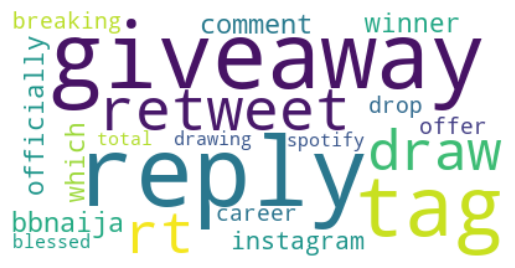

In [46]:
# Generate word cloud
wordcloud = WordCloud(background_color ='white')
wordcloud.generate_from_frequencies(word_freq)

# Plot
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [47]:
bottom_words = feature_impact.sort_values(by='impact', ascending=True).head(21)
bottom_words = bottom_words.drop(bottom_words.index[0])
bottom_word_freq = dict(zip(bottom_words.index, bottom_words['impact'].abs()))

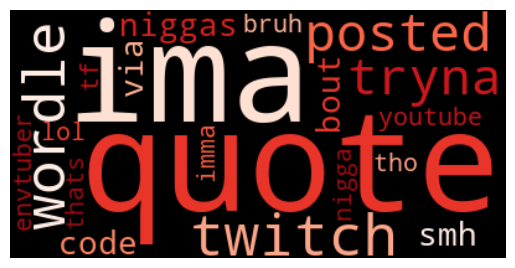

In [48]:
# Generate word cloud
wordcloud = WordCloud(colormap='Reds')
wordcloud.generate_from_frequencies(bottom_word_freq)

# Plot
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [49]:
bottom_word_freq

{'quote': 0.08430079599142794,
 'ima': 0.08062203589633739,
 'twitch': 0.08030576680139881,
 'wordle': 0.07861152508258187,
 'posted': 0.06387083262536707,
 'tryna': 0.06101951990951984,
 'niggas': 0.059797402702684944,
 'via': 0.059081215014328475,
 'code': 0.05853065272887451,
 'bout': 0.05844497503860191,
 'smh': 0.05774593183862259,
 'youtube': 0.0549606977840851,
 'bruh': 0.05422813421204586,
 'envtuber': 0.05341196223651943,
 'nigga': 0.0529905938487701,
 'lol': 0.0519820597589209,
 'tf': 0.049948557831215774,
 'thats': 0.049368058369707604,
 'imma': 0.0486151447929351,
 'tho': 0.047418188139956186}

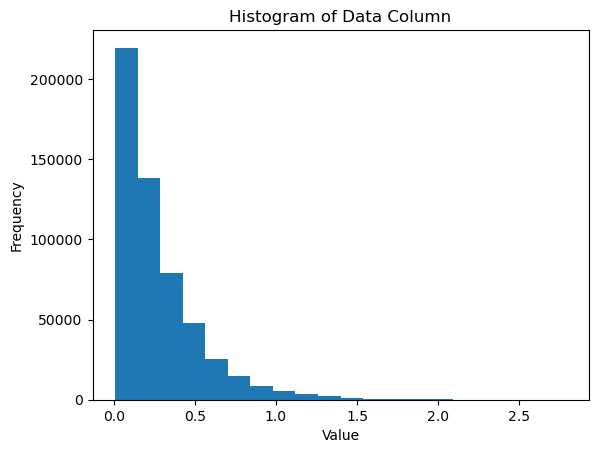

In [50]:
plt.hist(df['totalScore'], bins=20)

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data Column')

plt.show()

In [51]:
# Calculate percentiles for the specified column
percentiles = [0.25, 0.5, 0.75]  # 25th, 50th (median), and 75th percentiles
percentile_values = df['totalScore'].quantile(percentiles)

print(percentile_values)

0.25    0.125033
0.50    0.198650
0.75    0.371434
Name: totalScore, dtype: float64


In [52]:
# Calculate percentiles for the specified column
percentiles = [0.33, 0.66]
percentile_values = df['totalScore'].quantile(percentiles)

print(percentile_values)

0.33    0.125613
0.66    0.298396
Name: totalScore, dtype: float64


In [53]:
# Calculate percentiles for the specified column
percentiles = [0.2, 0.4, 0.6, 0.8, 0.9 ,0.99]
percentile_values = df['likeCount'].quantile(percentiles)

print(percentile_values)

0.20      1.0
0.40      2.0
0.60      4.0
0.80     11.0
0.90     26.0
0.99    466.0
Name: likeCount, dtype: float64


In [54]:
# Calculate percentiles for the specified column
df['followersCount'] = pd.to_numeric(df['followersCount'], errors='coerce')
percentiles = [0.8,0.96]
percentile_values = df['followersCount'].quantile(percentiles)

print(percentile_values)

0.80     4231.0
0.96    37613.0
Name: followersCount, dtype: float64


## LightGBM

In [55]:
train_data = lgb.Dataset(X, label=y)

In [56]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'n_estimators': 100
}

In [57]:
gbm = lgb.train(params, train_data)

C:\Users\varsh\anaconda3\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.715341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 205797
[LightGBM] [Info] Number of data points in the train set: 547476, number of used features: 1331
[LightGBM] [Info] Start training from score 0.224792


In [58]:
# Get feature importance
importance = gbm.feature_importance(importance_type='gain')

# Feature names
feature_names = vectorizer.get_feature_names_out()

# Combine names and importance scores
feature_importance = zip(feature_names, importance)

# Sort features by importance
sorted_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)

# Display the results
for word, score in sorted_importance:
    print(f"Word: '{word}', Importance: {score}")

Word: 'trueachievements', Importance: 287.9662261605263
Word: 'today', Importance: 237.9576095342636
Word: 'rt', Importance: 189.75166004896164
Word: 'the', Importance: 169.8648099899292
Word: 'first', Importance: 163.55969941616058
Word: 'thank', Importance: 147.4289522767067
Word: 'amp', Importance: 145.22095012664795
Word: 'follow', Importance: 131.8298728466034
Word: 'retweet', Importance: 124.49608606100082
Word: 'we', Importance: 121.0246970653534
Word: 'everyone', Importance: 99.82778322696686
Word: 'wordle', Importance: 99.3194974064827
Word: 'guys', Importance: 87.48373728990555
Word: 'people', Importance: 84.27194046974182
Word: 'new', Importance: 72.69231021404266
Word: 'morning', Importance: 72.56177324056625
Word: 'art', Importance: 70.68573278188705
Word: 'lol', Importance: 67.24850648641586
Word: 'giveaway', Importance: 65.24721372127533
Word: 'team', Importance: 61.99526834487915
Word: 'year', Importance: 61.804789662361145
Word: 'one', Importance: 60.46176493167877
Wor

In [59]:
y_pred = gbm.predict(X)

In [60]:
mse = mean_squared_error(y, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.030835474139117303
